## Load packages and functions

In [ ]:
import os
os.chdir("./concert/src")
os.getcwd()

In [2]:
import sys
import os
from time import time
import torch
from concert_batch_gut import CONCERT
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import h5py
import scanpy as sc
from preprocess import normalize, geneSelection
import pandas as pd

In [14]:
def str_list_to_unique_index(str_list):
        original_numbers = np.array([sum(ord(char) for char in s) for s in str_list])
        renumbered = {num: idx + 1 for idx, num in enumerate(sorted(set(original_numbers)))}
        new_numbers = [renumbered[num] for num in original_numbers]
        return np.array(new_numbers)

## Read data in h5 format

In [15]:
data_mat = h5py.File('../datasets/processed_gut_data.h5', 'r')
x = np.array(data_mat['X']).T.astype('float32') # count matrix
loc = np.array(data_mat['pos']).T.astype('float32') # location information
loc = loc[:, :2]
region_ = np.array(data_mat['region']).astype('str') # tissue information
region = str_list_to_unique_index(region_) - 1
perturbation_ = np.array(data_mat['perturbation']).astype('str') # perturbation information
perturbation = str_list_to_unique_index(perturbation_) - 1
genes = np.array(data_mat['gene']).astype('str') # gene names
day_ = np.array(data_mat['day']).astype('str') # perturbation information

## Build cell attribute matrix

In [77]:
day_ = np.array(data_mat['day']).astype('str') # perturbation information
mapping = {
    "D0":  (1., 0),
    "D12": (12., 1),
    "D30": (30., 2),
    "D73": (73., 3),
    }
day = []
batch = []
for i in day_:
    d, b = mapping[i]
    day.append(d)
    batch.append(b)
day = np.array(day)
num_classes = len(np.unique(batch))
batch = np.eye(num_classes)[batch]
cell_atts = np.concatenate((perturbation[:, None], day[:, None]), axis=1)
sample_indices = torch.tensor(np.arange(x.shape[0]), dtype=torch.int)
data_mat.close()
pert_dic = {perturbation_[i]: perturbation[i] for i in range(len(perturbation_))}
day_dic = {day_[i]: day[i] for i in range(len(day_))}

## scale, normalize data 

In [ ]:
n_batch = batch.shape[1]
loc_scaled = np.zeros(loc.shape, dtype=np.float64)
for i in range(n_batch):
        scaler = MinMaxScaler()
        b_loc = loc[batch[:,i]==1., :]
        b_loc = scaler.fit_transform(b_loc) * 20
        loc_scaled[batch[:,i]==1., :] = b_loc
loc = loc_scaled
loc = np.concatenate((loc, batch), axis=1)

# normalize data
adata = sc.AnnData(x, dtype="float32")
adata = normalize(adata,
                size_factors=True,
                normalize_input=True,
                logtrans_input=True)

## Setup inducing points

In [ ]:
#setup inducing points
eps = 1e-5
initial_inducing_points_0_ = np.mgrid[0:(1+eps):(1./6), 0:(1+eps):(1./6)].reshape(2, -1).T * 20
initial_inducing_points_0 = np.tile(initial_inducing_points_0_, (n_batch, 1))
initial_inducing_points_1 = []
for i in range(n_batch):
    initial_inducing_points_1_ = np.zeros((initial_inducing_points_0_.shape[0], n_batch))
    initial_inducing_points_1_[:, i] = 1
    initial_inducing_points_1.append(initial_inducing_points_1_)
initial_inducing_points_1 = np.concatenate(initial_inducing_points_1, axis=0)
initial_inducing_points = np.concatenate((initial_inducing_points_0, initial_inducing_points_1), axis=1)
print(initial_inducing_points.shape)

## Setup module

In [55]:
GP_dim = 2
Normal_dim = 8
encoder_layers = [128, 64]
decoder_layers = [64, 128]
noise = 0.1
dropoutE = 0
dropoutD = 0
shared_dispersion = True
fix_inducing_points = True
fixed_gp_params = False
kernel_scale = 20.
allow_batch_kernel_scale = True
KL_loss = 0.025
dynamicVAE = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
init_beta = 10
min_beta = 5
max_beta = 25
model = CONCERT(cell_atts=cell_atts, num_genes=adata.n_vars, input_dim=192, GP_dim=GP_dim, Normal_dim=Normal_dim, n_batch=n_batch, encoder_layers=encoder_layers, decoder_layers=decoder_layers,
        noise=noise, encoder_dropout=dropoutE, decoder_dropout=dropoutD, shared_dispersion=shared_dispersion,
        fixed_inducing_points=fix_inducing_points, initial_inducing_points=initial_inducing_points, 
        fixed_gp_params=fixed_gp_params, kernel_scale=kernel_scale, allow_batch_kernel_scale=allow_batch_kernel_scale,
        N_train=adata.n_obs, KL_loss=KL_loss, dynamicVAE=dynamicVAE, init_beta=init_beta, min_beta=min_beta, max_beta=max_beta, 
        dtype=torch.float32, device=device)

print(str(model))

Number of covariates:  2
CONCERT(
  (svgp): SVGP(
    (kernel): CauchyKernel()
    (sample_kernel): SampleKernel()
  )
  (encoder): DenseEncoder(
    (layers): Sequential(
      (0): Linear(in_features=192, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=64, out_features=32, bias=True)
      (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ELU(alpha=1.0)
    )
    (enc_mu): Linear(in_features=32, out_features=10, bias=True)
    (enc_var): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True

## Train model or load weights

In [56]:
model_file = 'model_gut.pt'
lr = 1e-3
weight_decay = 1e-6
batch_size = 256
num_samples = 1
train_size = 0.95
maxiter = 5000
patience = 200
if not os.path.isfile(model_file):
    t0 = time()
    model.train_model(pos=loc, ncounts=adata.X, raw_counts=adata.raw.X, size_factors=adata.obs.size_factors, batch=batch,
            lr=lr, weight_decay=weight_decay, batch_size=batch_size, num_samples=num_samples,
            train_size=train_size, maxiter=maxiter, patience=patience, save_model=True, model_weights=model_file)
    print('Training time: %d seconds.' % int(time() - t0))
else:
    model.load_model(model_file)

## Do counterfactual predictions

In [70]:
# for D12 predict for day 30, 50, and 73
pert_ind = np.where(day_ == 'D12')[0]
target_cell_day = [30., 50., 73.]
target_cell_perturbation = '0.0' # 0 since it's in recovered state at D12

out_counts = []
out_atts = []
for i in target_cell_day:
    print('Predicting for day %d ...' % i)
    perturbed_counts, perturbed_atts = model.counterfactualPrediction(X=loc, sample_index=sample_indices, cell_atts=cell_atts, batch_size=batch_size, n_samples=25,
                                                      perturb_cell_id = pert_ind,
                                                      target_cell_day = i, 
                                                      target_cell_perturbation = pert_dic[target_cell_perturbation]
                                                      )
    perturbed_counts = perturbed_counts[pert_ind,:]
    perturbed_atts = np.array([i]*perturbed_counts.shape[0])
    out_counts.append(perturbed_counts)
    out_atts.append(perturbed_atts) 

Predicting for day 30 ...
Predicting for day 50 ...
Predicting for day 73 ...


## Plot marker gene Clca4b for mouse D12 in day 30, 50, and 73 after perturbation

In [72]:
marker = 'Clca4b'
out_counts = np.concatenate(out_counts, axis=0)
out_atts = np.concatenate(out_atts, axis=0)
out_counts_f = out_counts[:,np.where(genes==marker)[0][0]]
pert_ind_f = np.concatenate([pert_ind,pert_ind,pert_ind],axis=0)
region_f = np.concatenate([region_[pert_ind]]*3,axis=0)

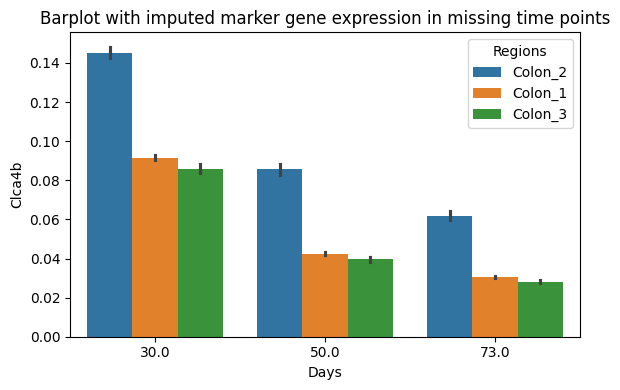

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    "Clca4b": out_counts_f,
    "Days": out_atts,
    "Regions": region_f
})

plt.figure(figsize=(6,4))
sns.barplot(
    data=df,
    x="Days",       # X-axis
    y="Clca4b",         # Height
    hue="Regions",     # Colors
    errorbar="se"      # standard error bars
)
plt.xlabel("Days")
plt.ylabel("Clca4b")
plt.title("Barplot with imputed marker gene expression in missing time points")
plt.legend(title="Regions")
plt.tight_layout()
plt.show()

## Plot positive regions in each time point using a cutoff 

In [103]:
cutoff = np.percentile(out_counts_f,80)
postive = (out_counts_f > cutoff).astype(int)

In [90]:
data_mat = h5py.File('../datasets/processed_gut_data.h5', 'r')
loc = np.array(data_mat['pos']).T.astype('float32') # location information
loc = loc[:, :2]
loc = np.concatenate([loc[pert_ind,:]]*3, axis=0)

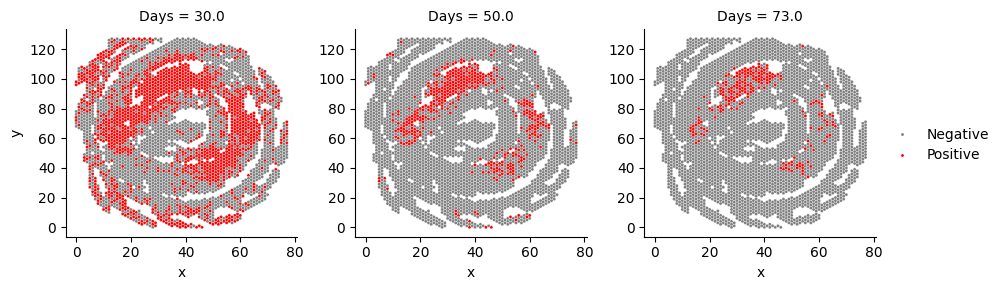

In [104]:
df = pd.DataFrame({
    "x": loc[:,0],
    "y": loc[:,1],
    "Positive": postive,
    "Days": out_atts,
})

df["label"] = df["Positive"].map({0: "Negative", 1: "Positive"})

palette = {"Negative": "grey", "Positive": "red"}

g = sns.FacetGrid(df, col="Days", col_wrap=3, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="x", y="y", hue="label", palette=palette, s=5)
g.add_legend()
plt.show()